# Computing the tritronquée "potential" $\mathcal{V}(y;\tau)$ of Painlevé-II

This notebook involves the code that's used in the paper [Bilman&Miller, 2024], __Asymptotic Properties of General Rogue Waves of Infinite Order__ to compute the function $\mathcal{V}(y;\tau)$ associated with the so-called increasing tritronquée solution of the Painevé-II equation.

In [6]:
# Painleve2TT
using Distributed
addprocs()
@everywhere using OperatorApproximation, LinearAlgebra
@everywhere using HDF5

In [8]:
@everywhere global ϵ = 10^(-12)
@everywhere global ymax = 0.2
@everywhere global dy = 0.005
@everywhere global ygrid = Array(-ymax:dy:ymax)

The routine below does much more than computing $\mathcal{V}(y;\tau)$. It has many several additional quantities returned for testing purposes.

In [10]:
@everywhere function P2_TritronqueeV_RHP(y, τ, npts::Integer)
    pval = log(1+τ^2)/(2*π)
    radout = max(8.0, 2*sqrt(abs(ymax)), sqrt(abs(ymax))/sqrt(6))
    radin = 1.0

    # OUTWARDS-oriented rays from the circrle in the ζ-plane extending to ∞
    Γout = [radin*exp(1im*π/2) radout*exp(1im*π/2); radin*exp(1im*5*π/6) radout*exp(1im*5*π/6); radin*exp(-1im*5*π/6) radout*exp(-1im*5*π/6); radin*exp(-1im*π/2) radout*exp(-1im*π/2)]

    # OUTWARDS-oriented rays from the origin to the circle in the ζ-plane
    Γin = [0 radin*exp(1im*π/2); 0 radin*exp(1im*5*π/6); 0 radin*exp(1im*π); 0 radin*exp(-1im*5*π/6); 0 radin*exp(-1im*π/2)]
    
    # Segments mimicking the unit circle, oriented counter-clockwise,
    # just like the order of the segments above.
    # Compare with Figure 8 in the article P. Miller 2018 (SIGMA).
    𝕋 = [radin*exp(1im*π/2) radin*exp(1im*5*π/6); radin*exp(1im*5*π/6) radin*exp(1im*π); radin*exp(1im*π) radin*exp(-1im*5*π/6); radin*exp(-1im*5*π/6) radin*exp(-1im*π/2); radin*exp(-1im*π/2) radin; radin radin*exp(1im*π/2)]
    Σ = vcat(Γout, Γin, 𝕋)

    # Jump matrices
    Jout_12 = [z->1 z->0; z->τ*z^(2im*pval)*exp(-1im*(z^3+y*z)) z->1]
    Jout_23 = [z->1 z->-τ*exp(-2*π*pval)*z^(-2im*pval)*exp(1im*(z^3+y*z)); z->0 z->1]
    Jout_34 = [z->1 z->0; z->-τ*exp(-2*π*pval)*z^(2im*pval)*exp(-1im*(z^3+y*z)) z->1]
    Jout_45 = [z->1 z->τ*z^(-2im*pval)*exp(1im*(z^3+y*z)); z->0 z->1]
    Jin_12 = [z->1 z->0; z->τ*exp(-1im*(z^3+y*z)) z->1]
    Jin_23 = [z->1 z->-τ*exp(-2*π*pval)*exp(1im*(z^3+y*z)); z->0 z->1]
    Jin_34 = [z->exp(-2*π*pval) z->0; z->0 z->exp(2*π*pval)]
    Jin_45 = [z->1 z->0; z->-τ*exp(-2*π*pval)*exp(-1im*(z^3+y*z)) z->1]
    Jin_56 = [z->1 z->τ*exp(1im*(z^3+y*z)); z->0 z->1]
    # Jump on the circle repeats 6 times.
    JT = [z->z^(-1im*pval) z->0; z->0 z->z^(1im*pval)]
    JTup = [z->(z+ϵ*1im)^(-1im*pval) z->0; z->0 z->(z+ϵ*1im)^(1im*pval)]
    JTdown = [z->(z-ϵ*1im)^(-1im*pval) z->0; z->0 z->(z-ϵ*1im)^(1im*pval)]
    # Collected jumps
    # J = [Jout_12, Jout_23, Jout_34, Jout_45, Jin_12, Jin_23, Jin_34, Jin_45, Jin_56, JT, JT, JT, JT, JT, JT]
    J = [Jout_12, Jout_23, Jout_34, Jout_45, Jin_12, Jin_23, Jin_34, Jin_45, Jin_56, JT, JTup, JTdown, JT, JT, JT]
    rhp = RHP(Σ, J)
    rhp_solver = RHSolver(rhp)
    numarcs = length(J)
    u1 = rhp_solver([1 0],numarcs*npts)
    u2 = rhp_solver([0 1],numarcs*npts)
    U = rhp_solver(([1 0], [0 1]), numarcs*npts)
    U = hcat(U...) |> transpose |> Matrix
    Usums = sum.(U)
    pain2 = -(1/(2im*π))*Usums[2,1]
    return pain2, rhp, rhp_solver, U, u1, u2
end

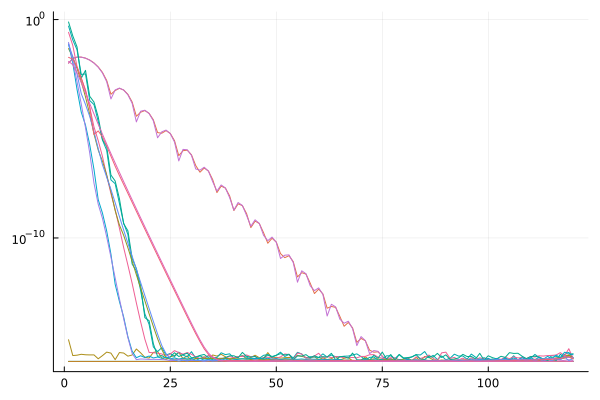

In [12]:
# Check the coefficients of the computed solution.
length(ygrid)
@everywhere global tauval = 1.
ytest=ygrid[1]
ytest=0.1
outpain2, outrhpP2, outrhp_solverP2, outUP2, outu1P2, outu2P2 = P2_TritronqueeV_RHP(ytest,tauval, 240);

coefplot(outu1P2[2], legend=false)

## Computing for the paper

In [17]:
@everywhere function P2_TritronqueeV(y, τ, npts::Integer)
    pval = log(1+τ^2)/(2*π)
    radout = max(8.0, 2*sqrt(abs(ymax)), sqrt(abs(ymax))/sqrt(6))
    radin = 1.0
	
    # OUTWARDS-oriented rays from the circrle in the ζ-plane extending to ∞
    Γout = [radin*exp(1im*π/2) radout*exp(1im*π/2); radin*exp(1im*5*π/6) radout*exp(1im*5*π/6); radin*exp(-1im*5*π/6) radout*exp(-1im*5*π/6); radin*exp(-1im*π/2) radout*exp(-1im*π/2)]

    # OUTWARDS-oriented rays from the origin to the circle in the ζ-plane
    Γin = [0 radin*exp(1im*π/2); 0 radin*exp(1im*5*π/6); 0 radin*exp(1im*π); 0 radin*exp(-1im*5*π/6); 0 radin*exp(-1im*π/2)]
    
    # Segments mimicking the unit circle, oriented counter-clockwise,
    # just like the order of the segments above.
    # Compare with Figure 8 in the article P. Miller 2018 (SIGMA).
    𝕋 = [radin*exp(1im*π/2) radin*exp(1im*5*π/6); radin*exp(1im*5*π/6) radin*exp(1im*π); radin*exp(1im*π) radin*exp(-1im*5*π/6); radin*exp(-1im*5*π/6) radin*exp(-1im*π/2); radin*exp(-1im*π/2) radin; radin radin*exp(1im*π/2)]
    Σ = vcat(Γout, Γin, 𝕋)

    # Jump matrices
    Jout_12 = [z->1 z->0; z->τ*z^(2im*pval)*exp(-1im*(z^3+y*z)) z->1]
    Jout_23 = [z->1 z->-τ*exp(-2*π*pval)*z^(-2im*pval)*exp(1im*(z^3+y*z)); z->0 z->1]
    Jout_34 = [z->1 z->0; z->-τ*exp(-2*π*pval)*z^(2im*pval)*exp(-1im*(z^3+y*z)) z->1]
    Jout_45 = [z->1 z->τ*z^(-2im*pval)*exp(1im*(z^3+y*z)); z->0 z->1]
    Jin_12 = [z->1 z->0; z->τ*exp(-1im*(z^3+y*z)) z->1]
    Jin_23 = [z->1 z->-τ*exp(-2*π*pval)*exp(1im*(z^3+y*z)); z->0 z->1]
    Jin_34 = [z->exp(-2*π*pval) z->0; z->0 z->exp(2*π*pval)]
    Jin_45 = [z->1 z->0; z->-τ*exp(-2*π*pval)*exp(-1im*(z^3+y*z)) z->1]
    Jin_56 = [z->1 z->τ*exp(1im*(z^3+y*z)); z->0 z->1]
    # Jump on the circle repeats 6 times.
    
    JT = [z->z^(-1im*pval) z->0; z->0 z->z^(1im*pval)]
    JTup = [z->(z+ϵ*1im)^(-1im*pval) z->0; z->0 z->(z+ϵ*1im)^(1im*pval)]
    JTdown = [z->(z-ϵ*1im)^(-1im*pval) z->0; z->0 z->(z-ϵ*1im)^(1im*pval)]
    # Collected jumps
    # J = [Jout_12, Jout_23, Jout_34, Jout_45, Jin_12, Jin_23, Jin_34, Jin_45, Jin_56, JT, JT, JT, JT, JT, JT]
    J = [Jout_12, Jout_23, Jout_34, Jout_45, Jin_12, Jin_23, Jin_34, Jin_45, Jin_56, JT, JTup, JTdown, JT, JT, JT]
    rhp = RHP(Σ, J)
    rhp_solver = RHSolver(rhp)
    numarcs = length(J)
    # u1 = rhp_solver([1 0],numarcs*npts)
    # u2 = rhp_solver([0 1],numarcs*npts)
    U = rhp_solver(([1 0], [0 1]), numarcs*npts)
    U = hcat(U...) |> transpose |> Matrix
    Usums = sum.(U)
    V = -(1/(2im*π))*Usums[2,1]
    return V
end

@everywhere function TritronqueeVmap(y)
    return P2_TritronqueeV(y,tauval, 240)
end

In [ ]:
outTritronqueeVvals = pmap(TritronqueeVmap,ygrid)

h5write("P2dataForV.h5", "ygrid", ygrid)
h5write("P2dataForV.h5", "tauval", tauval)
h5write("P2dataForV.h5", "realV", real.(outTritronqueeVvals))
h5write("P2dataForV.h5", "imagV", imag.(outTritronqueeVvals))
h5write("P2dataForV.h5", "absV", abs.(outTritronqueeVvals))